In [1]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import statsmodels.api as sm

In [2]:
def plot_mean_std(df,x_data ='month'):
    
    fig, axs = plt.subplots(3, sharex=True, sharey=False,figsize=(11,7))
    fig.suptitle('Sharing both axes')
    
    ind = list(df[x_data])
    
    axs[0].errorbar(x=ind,y=list(df.delta_exits['mean']),yerr=list(df.delta_exits['std']),fmt='o',capsize = 5)
    axs[0].set_ylabel('daily -  entries')
    axs[0].set_xlabel('MONTH')
    axs[0].set_xticks(ind)
    
    subplots_adjust(left=0.125, bottom = 0.1, right = 0.9, top = 0.9, wspace=0.2, hspace=0.4)
    
    axs[1].errorbar(x=ind,y=list(df.delta_exits['mean']), yerr=list(df.delta_exits['std']),fmt='o',capsize = 5)
    axs[1].set_ylabel('daily - exits')
    axs[1].set_xlabel(x_data)
    axs[1].set_xticks(ind)
    
    subplots_adjust(left=0.125, bottom = 0.1, right = 0.9, top = 0.9, wspace=0.2, hspace=0.4)
    
    axs[2].errorbar(x=ind,y=list(df.total_traffic['mean']), yerr=list(df.total_traffic['std']),fmt='o',capsize = 5)
    axs[2].set_ylabel('daily - total traffic')
    axs[2].set_xlabel(x_data)
    axs[2].set_xticks(ind)
        
    fig.suptitle('Mean and Standard Deviation of the daily total number of entries, exits and net')




def total_traffic_weekday_box(df, title):
    
    df_pre = df[['time', 'dow', 'total_traffic', 'station']]
    df1 = df_pre.groupby([pd.Grouper(key='time', freq='1D'), 'dow', 'station']).sum().reset_index()

    fig, ax1 = plt.subplots(figsize=(15,8))
    ax = sns.boxplot(x='dow', y='total_traffic', data=df1, showfliers=False, ax=ax1)
    ax.set_ylabel('daily passengers traffic')
    ax.set_xlabel('week day')
    ax.set_title(title)
    fig.show()


    

#return top 10 stations
def top_10_stations(df):
    
    df1 = df.groupby(['station', pd.Grouper(key='time', freq='1D')]).sum().reset_index().groupby(['station']).mean().total_traffic.sort_values(ascending=False)
    
    stations = df1.reset_index().station.unique()[:10]
        
    df2 = df[df.station.apply(lambda x: x in stations)][['station', 'time', 'total_traffic', 'dow','time_2']]
        
    return df2



def preprocess(df):
    
    # STANDARDIZE COL NAMES
    df.columns = df.columns.str.strip()
    
    # Create 'DOW' (Day of Week) col from 'DATETIME'
    df['dow'] = df[['time']].apply(lambda x: datetime.strftime(x['time'], '%A'), axis=1)
       
    # DROP UNNECESSARY COLUMNS
    df = df.drop(['linename', 'division'], axis=1) 

    # Remove non-REGULAR values from 'DESC'
    df = df.drop(df.loc[df.desc != 'REGULAR'].index)
    df = df.drop(['desc'], axis=1) 
    
    return df



""" 

shows average daily volume traffic across time for differnte stations for N stations

"""

def plot_series_trafic_stations(df, n_stations = 10):
        
    # group into daily then avg then
    
        # Take only relavent columns
    df_pre = df[['station', 'time', 'total_traffic', 'time_2']] 
    
    # Group into dailies through sum and then find the average for stations per day
    df1 = df_pre.groupby(['station', pd.Grouper(key='time', freq='1D')])\
    .sum()\
    .reset_index()\
    .groupby(['station'])\
    .mean()\
    .total_traffic\
    .sort_values(ascending=False)[0:n_stations]
    
    
    # Collection station labels
    stations = df1.reset_index().station.unique()
    
     # Create new dataframe 
    df2 = df[df.station.apply(lambda x: x in stations)].copy()
    
    # Create time columnn
    df3 = df2.groupby(['station', 'time', 'time_2']).sum().reset_index().groupby(['station', 'time_2']).mean().reset_index()
        
    # Plot
    fig, ax = plt.subplots(figsize=(15,8))
    labels = []
    for key, grp in df3.groupby('station'):
        labels.append(key)
        _ = grp.plot(ax=ax, x='time_2', y='total_traffic')

    lines, _ = ax.get_legend_handles_labels()
    ax.legend(lines, labels, loc='best')
    #ax.set_xticks(df3.TIME.tolist())
    ax.set_ylabel('entry + exi')
    ax.set_xlabel('time')
    ax.set_title('avg total traffic')
    fig.show()


    
    
# plot total passenger volume flow within a given periodicity: hourly, daily, month, yearly, buy weekday
#def plot_by_periodicity:
#    pass

## 1. Exploratory data analysis: Goals
* The goal of this taks is to read, understand, clean and make adjustaments on the dataset in order the get useful insights and have a better understanding on the model predictor to be built later on


* Also, in this module, as get we get familiar with the data, useuful features may crated for training the models,


* Pre-processing steps as dimensionality reduction, feature selection/extraction as well as model's fitting and evaluation will be constructed on the next part 

## 2. About the data
* The dataset provided is the merge of all weekly cvs data
* each row on the dataset represents an observation at a give moment for a specific turnstile
* The readings happens every 4 hour
* Each turnstile is in a "Control area", which is the bank group of turnstiles associated with a subway exit 
* Each control area is a remoted unit 
* each station might have more than 1 remote unti
* Each turnstile is indetified by its "SCP" + "ca" + "unit"
* each "entries" represents how many observations there were for a give turnstile. 
* the entries counter variable resets after reachs its maximum value, that is, if previous_value > current_value it means that it has been reset

## 3. Reading data

In [3]:
df_2017 = pd.read_csv("nyc_2017.csv")
# fixing date for datetime format
#df_2017['time'] = pd.to_datetime(datetime, format='%Y-%d-%M %H:%M:%S', errors='coerce')
#df_2017['time'] = df_2017['time'].apply(lambda x: datetime.strptime(x,'%Y-%d-%m %H:%M:%S'))
df_2017["time"] = df_2017["time"].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
df_2017.head(2)

,time,ca,unit,scp,station,linename,division,desc,entries,exits
0,2017-01-01,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,5992418.0,2028543.0
1,2017-01-01,A002,R051,02-00-01,59 ST,NQR456W,BMT,REGULAR,5475502.0,1204841.0


In [4]:
# adding unique id
df_2017['id'] = df_2017['ca'] + '-' + df_2017['unit'] + '-' + df_2017['scp']

In [5]:
# checking that there is only one ID (turnstile) per station
df_2017.groupby('id').station.nunique().reset_index().sort_values("station").head(3)

,id,station
0,A002-R051-02-00-00,1
3177,R143-R032-02-03-03,1
3176,R143-R032-02-03-02,1


In [6]:
# sorting and reseting index so we can add new columsn properly later on!
df_2017 = df_2017.sort_values(['station','id','time']).reset_index()

# 4. checking unique values per variables

In [8]:
# checking dif values
values = []
cols = df_2017.columns.tolist()
cols = [el for el in cols if el not in ['index']]
for col in cols:
    values.append(df_2017[col].unique().__len__())

pd.DataFrame({"variables":cols,"n_unique_values":values})

,variables,n_unique_values
0,time,479655
1,ca,737
2,unit,470
3,scp,234
4,station,380
5,linename,114
6,division,6
7,desc,2
8,entries,4567747
9,exits,4086606


In [7]:
df_2017.head()

,index,time,ca,unit,scp,station,linename,division,desc,entries,exits,id
0,414,2017-01-01 00:00:00,H007,R248,00-00-00,1 AV,L,BMT,REGULAR,11894473.0,13052475.0,H007-R248-00-00-00
1,5011,2017-01-01 04:00:00,H007,R248,00-00-00,1 AV,L,BMT,REGULAR,11895162.0,13053430.0,H007-R248-00-00-00
2,9613,2017-01-01 08:00:00,H007,R248,00-00-00,1 AV,L,BMT,REGULAR,11895481.0,13054078.0,H007-R248-00-00-00
3,14207,2017-01-01 12:00:00,H007,R248,00-00-00,1 AV,L,BMT,REGULAR,11895565.0,13054361.0,H007-R248-00-00-00
4,18806,2017-01-01 16:00:00,H007,R248,00-00-00,1 AV,L,BMT,REGULAR,11895737.0,13054651.0,H007-R248-00-00-00


In [9]:
df_2017 = preprocess(df_2017)
df_2017.head()

,index,time,ca,unit,scp,station,entries,exits,id,dow
0,414,2017-01-01 00:00:00,H007,R248,00-00-00,1 AV,11894473.0,13052475.0,H007-R248-00-00-00,Sunday
1,5011,2017-01-01 04:00:00,H007,R248,00-00-00,1 AV,11895162.0,13053430.0,H007-R248-00-00-00,Sunday
2,9613,2017-01-01 08:00:00,H007,R248,00-00-00,1 AV,11895481.0,13054078.0,H007-R248-00-00-00,Sunday
3,14207,2017-01-01 12:00:00,H007,R248,00-00-00,1 AV,11895565.0,13054361.0,H007-R248-00-00-00,Sunday
4,18806,2017-01-01 16:00:00,H007,R248,00-00-00,1 AV,11895737.0,13054651.0,H007-R248-00-00-00,Sunday


## 5. Dropping Na

In [10]:
# Drop Nulls created by previous cell
print("prior shape: ", df_2017.shape)
df_2017.dropna(how='any', inplace=True)
print("post shape: ", df_2017.shape)

prior shape:  (7436484, 10)
post shape:  (7436484, 10)


## 6. Checking duplicates
 * A a given ID (turnstile) and a given timeframe, it is expected to a unique row

In [15]:
# DROP DUPLICATES
print("prior shape: ", df_2017.shape)
df_2017.drop_duplicates(subset=["id", "time"], inplace=True)
print("post shape: ", df_2017.shape)

prior shape:  (7436484, 10)
post shape:  (7436484, 10)


#### conclusions:
1) as show in the table, there is an average of 1.6 scp per stations

# 7: Generating flow inscreases columns
 * In order to know the overall daily inscrease in passengers using the subway, we need to calculate the daily inscreave
   within each id_turnstile. 
   
 
 * This way, we can easily aggregate in various others ways (by time, area, station etc)
 

In [16]:
df_2017.head(2)

,index,time,ca,unit,scp,station,entries,exits,id,dow
0,414,2017-01-01 00:00:00,H007,R248,00-00-00,1 AV,11894473.0,13052475.0,H007-R248-00-00-00,Sunday
1,5011,2017-01-01 04:00:00,H007,R248,00-00-00,1 AV,11895162.0,13053430.0,H007-R248-00-00-00,Sunday


In [17]:
df_2017 = df_2017.sort_values(['station', 'ca', 'unit', 'scp','time'])
# Create diff columns to take entries/exits for given time interval
df_2017['delta_entries'] = df_2017.groupby(['station', 'ca', 'unit', 'scp'], as_index=False)['entries'].diff().tolist()
df_2017['delta_exits'] = df_2017.groupby(['station', 'ca', 'unit', 'scp'], as_index=False)['exits'].diff().tolist()

## 8. Plotting grouped daily inscreases distribuitions and removing outliers

In [18]:
%pylab inline
import matplotlib
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


C:\Users\lucas.oliveira\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [19]:
# check distribution of entries_diff and exits_diff
print('Descriptions of delta_exits:')
print(df_2017['delta_exits'].describe())
print('')
print('Descriptions of delta_exits:')
print(df_2017['delta_entries'].describe())

Descriptions of entries_diff:
count    7.431719e+06
mean     2.297994e+03
std      3.136405e+06
min     -1.879048e+09
25%      8.000000e+00
50%      5.100000e+01
75%      1.630000e+02
max      2.088503e+09
Name: delta_exits, dtype: float64

Descriptions of exits_diff:
count    7.431719e+06
mean     2.900869e+03
std      3.044183e+06
min     -2.078544e+09
25%      9.000000e+00
50%      7.500000e+01
75%      2.420000e+02
max      2.122193e+09
Name: delta_entries, dtype: float64


In [20]:
2.130669e+09/2.470000e+02

8626190.28340081

### OBS:  The maximum value is more the 8 milion time larger the the 75th percentile, making it clear the need for outlier filtering. Apparently, in this year dataset there is no negative value for  entries, as should be

## 8. checking entries/exits inscrease throughout the whole dataset (sampled)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026E99186C88>,
      dtype=object)

<Figure size 432x288 with 0 Axes>

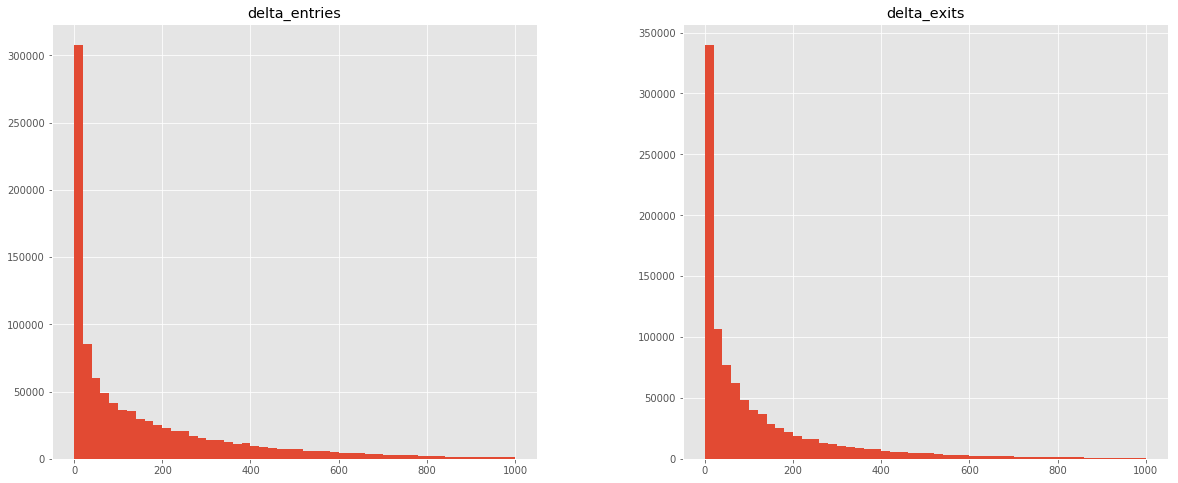

In [21]:
plt.figure()
samplesize = 1000000 # 1 million
histparams = { 'bins':50, 'range':(0,1000), 'figsize':(20, 8) }

# sampling the dataframe for faster plot
df_samples = df_2017.sample(n=samplesize).loc[:,['delta_exits','delta_entries']]
df_samples.hist(**histparams)

In [22]:
# Checking data loss for removing outliers
def perc_of_total_data(df_new,df_old):
    '''see how much cleaning a dataset reduced its size'''
    return float(df_new.shape[0]) / df_old.shape[0]

In [23]:
cap = 5000
for col in ['delta_exits','delta_entries']:
    df_above_cap = df_2017[df_2017[col] > cap]
    print('capping {} to < {}, results in removing {:.1%} of our data'.format(col, cap, perc_of_total_data(df_above_cap, df_2017)))

capping delta_exits to < 5000, results in removing 0.0% of our data
capping delta_entries to < 5000, results in removing 0.0% of our data


In [24]:
for col in ['delta_exits', 'delta_entries']:
    df_2017.ix[df_2017[col] > cap, col] = np.nan

C:\Users\lucas.oliveira\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [25]:
df_2017["delta_entries"].max()/240

20.804166666666667

### Sanity check:
* Now, the max value is 4886, that  represents about 20 people/ minute passing on the turnstil, which seems reasonable

### Conclusion: As for this model development we dont lack of data, having several years of store data, we rather clean out  the outliers in order not to comprise the model's resuts

## 10. Checking for negative if there is entries rows  < 0. If so, replace it with NaN

In [26]:
print('number of rows below zero:', df_2017[df_2017.delta_entries < 0].shape[0], 'and', df_2017[df_2017.delta_exits < 0].shape[0])

number of rows below zero: 47712 and 33454


In [27]:
## DROP NEGATIVES
print("prior shape: ", df_2017.shape)
df_2017 = df_2017.loc[ (df_2017['delta_entries'] > 0) & (df_2017['delta_exits'] > 0) ]
print("post shape: ", df_2017.shape)

prior shape:  (7436484, 12)
post shape:  (6020705, 12)


## 11. net passengers: entry  + exit

In [28]:
# the fair quantity to describe how much a given turnstile have been used on a given time frame is the sum of entries + exitis
df_2017['total_traffic'] = df_2017.delta_exits + df_2017.delta_entries

## 12. additional time features

In [29]:
from datetime import datetime

df_2017['minute'] = df_2017['time'].dt.minute
df_2017['hour'] = df_2017['time'].dt.hour
df_2017['month'] = df_2017['time'].dt.month
df_2017['year'] = df_2017['time'].dt.year
df_2017['day_week'] = df_2017['time'].dt.dayofweek
df_2017['day_year'] = df_2017['time'].dt.dayofyear
df_2017['week_year'] = df_2017['time'].dt.weekofyear

# day of the week
df_2017["dow"] = df_2017["time"].apply(lambda x: datetime.strftime(x, '%A'))


#time_2: hours, minute and seconds
df_2017["time_2"] = df_2017["time"].apply(lambda x: x.time())

## 13. quantifying passengers traffic for 1 year period (all stations)

In [58]:
# grab data that lies within the day and sort by datetime
range_augfirst = (df_2017.time >= datetime(2017, 1, 1)) & \
                 (df_2017.time <  datetime(2017, 12,31))


df_augfirst = df_2017[range_augfirst]
print("Total traffic numbers in 2017")
print("Entries {:,}".format(df_augfirst.delta_entries.sum()))
print("Exits   {:,}".format(df_augfirst.delta_exits.sum()))

Total traffic numbers in 2017
Entries 718,840,055.0
Exits   544,411,236.0


## 14. Aggrregating  total traffic

### 14.1 total traffic across all stations
 * As there is to many statiosm  (380), we are going to take a look at the ones that represents the largest portion of traffic in NYC among all.

In [32]:
# all sttatios
df_group_station = df_2017.groupby(['station']).agg({'total_traffic': sum}).sort_values(by = 'total_traffic', ascending = False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026FCD3CB390>]],
      dtype=object)

<Figure size 432x288 with 0 Axes>

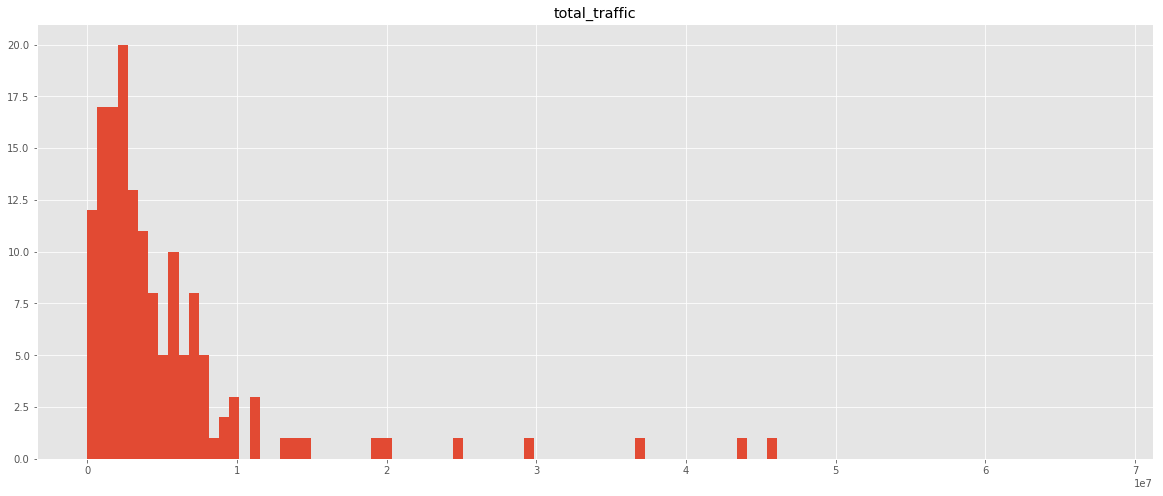

In [33]:
# total traffic distribution for all stations
plt.figure()
samplesize = 150 # 1 million
histparams = { 'bins':100, 'range':(0,df_group_station["total_traffic"].max()), 'figsize':(20, 8) }

# sampling the dataframe for faster plot
df_samples = df_group_station.reset_index().sample(n=samplesize).loc[:,['total_traffic']]
df_samples.hist(**histparams)

C:\Users\lucas.oliveira\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


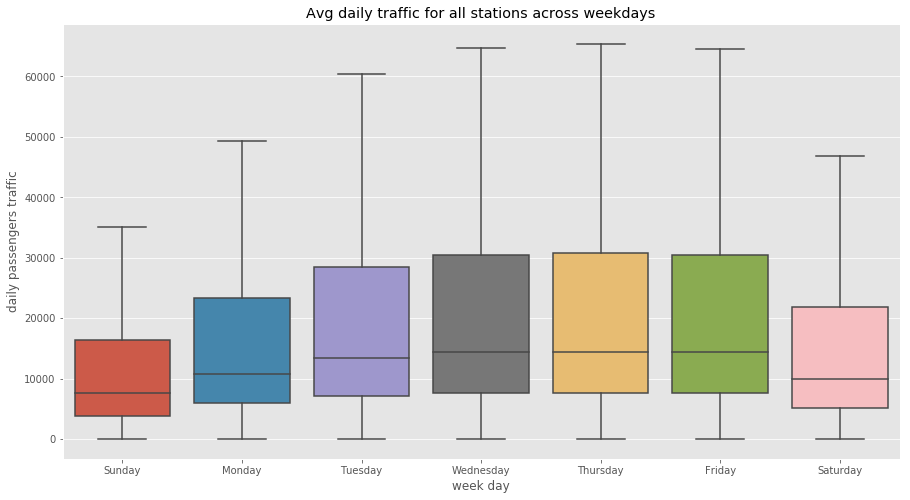

In [34]:
# box plot for daily traffic (weekdays) - all stations
total_traffic_weekday_box(df_2017, 'Avg daily traffic for all stations across weekdays')

### 14.2 total traffic for top 10 stations

In [35]:
# group of top 10 stations according to its traffic load (daily data)
df_top_10 = top_10_stations(df_2017)

In [36]:
# top 10 highest traffic load
top_10 = df_group_station.head(10)
top_10

,total_traffic
station,
34 ST-PENN STA,67778872.0
GRD CNTRL-42 ST,60494798.0
34 ST-HERALD SQ,50360267.0
14 ST-UNION SQ,46014568.0
TIMES SQ-42 ST,43942136.0
23 ST,43913556.0
FULTON ST,37279802.0
42 ST-PORT AUTH,37053790.0
86 ST,35976227.0


In [37]:
print("the ratio between top 10 traffic stations and the total is: {}".format(top_10["total_traffic"].sum()/df_2017["total_traffic"].sum()))

the ratio between top 10 traffic stations and the total is: 0.19951368391349725


In [38]:
max_station = top_10.index[0]
max_station

'34 ST-PENN STA'

In [39]:
# ratio between max and min total traddic from top 10 stations
top_10["total_traffic"].min()/top_10["total_traffic"].max()

0.44905042090402447

C:\Users\lucas.oliveira\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


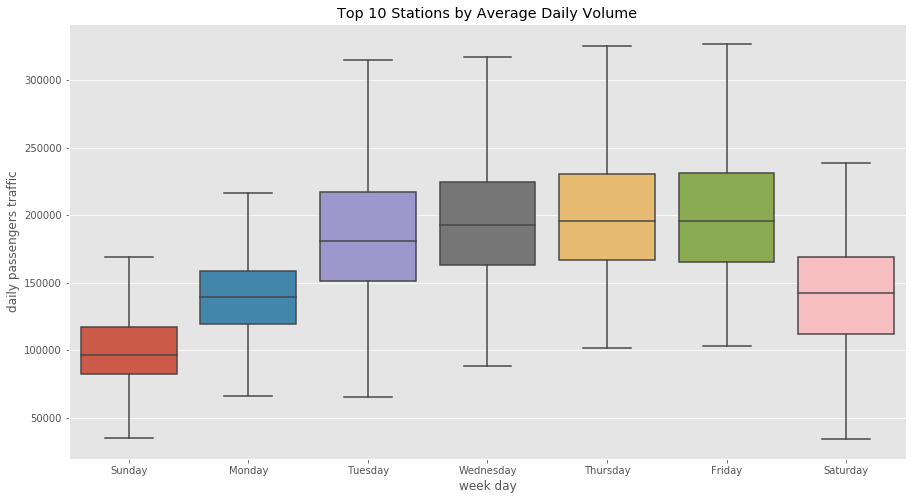

In [40]:
# box plot for daily traffic (weekdays) - top 10 stations
total_traffic_weekday_box(df_top_10, "Top 10 Stations by Average Daily Volume")

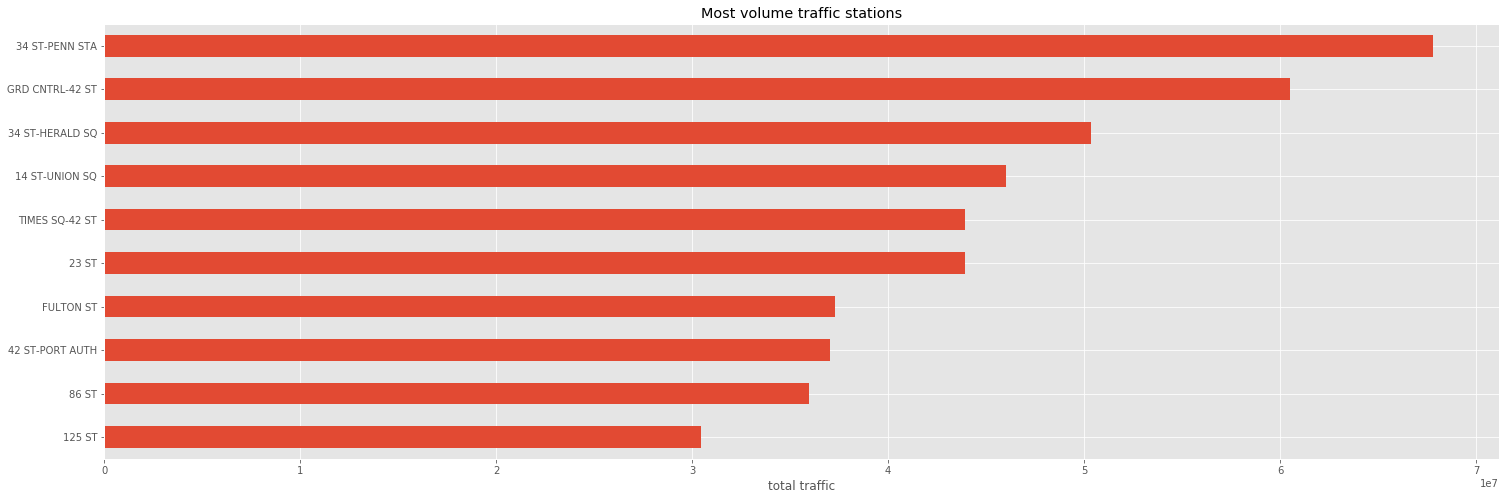

In [41]:
fig, ax = plt.subplots(figsize=(25, 8))
top_10.sort_values(by = 'total_traffic',ascending=True).plot(kind='barh',ax=ax)
ax.set(title='Most volume traffic stations', xlabel='total traffic', ylabel='')
ax.legend().set_visible(False)

In [42]:
max_df = df_2017[df_2017["station"]==max_station]

In [43]:
# dif values for max_staion
values = []
cols = max_df.columns.tolist()
cols = [el for el in cols if el in ['id','unit','division','linename','ca']]
for col in cols:
    values.append(max_df[col].unique().__len__())

pd.DataFrame({"variables":cols,"n_unique_values":values})

,variables,n_unique_values
0,ca,13
1,unit,4
2,id,92


### '34 ST-PENN STA' station  has 4 remote units and 98 turnstile

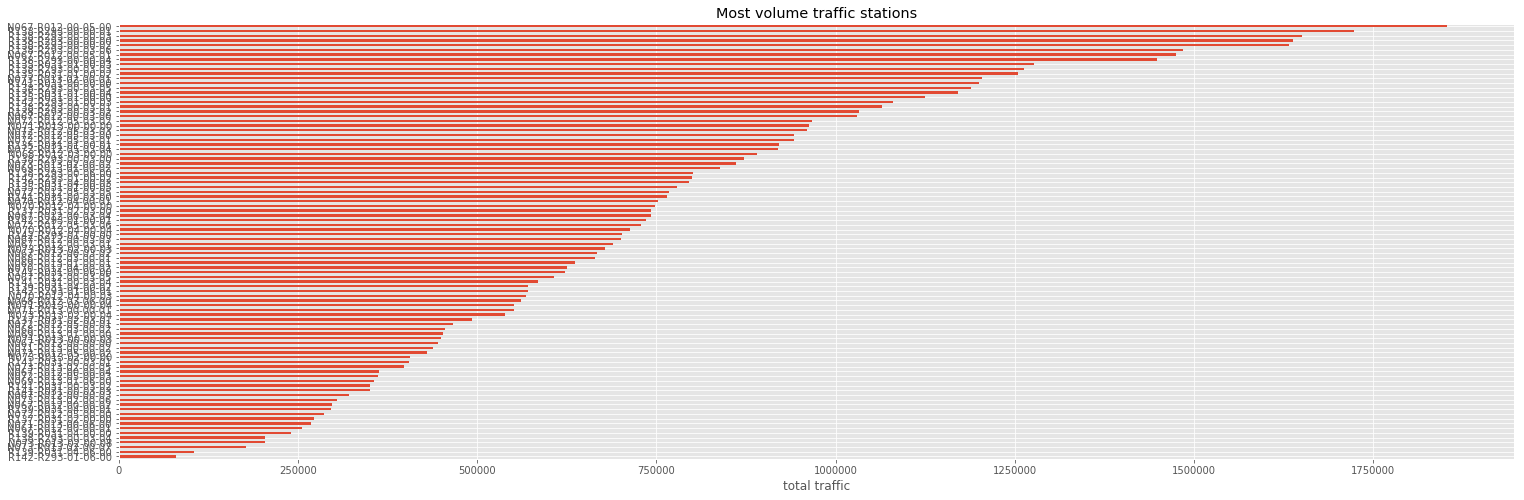

In [44]:
# the same way, we plot the main turnstile of ST-PENN S TA
fig, ax = plt.subplots(figsize=(25, 8))
max_df.groupby("id").agg({"total_traffic":"sum"}).sort_values(by = 'total_traffic',ascending=True).plot(kind='barh',ax=ax)
ax.set(title='Most volume traffic stations', xlabel='total traffic', ylabel='')
ax.legend().set_visible(False)

C:\Users\lucas.oliveira\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


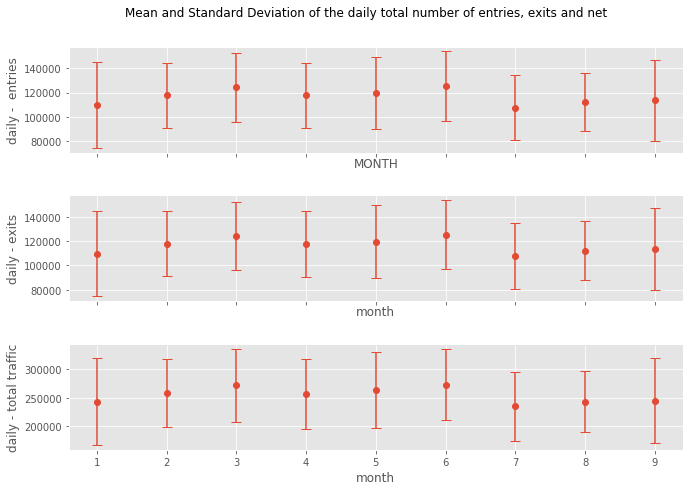

In [45]:
max_df["date"] = max_df["time"].apply(lambda x: x.date())

# calculate the daily entries and exits for Q1 2013
daily_data = max_df.groupby(['month','date'])[['delta_exits','delta_entries','total_traffic']].sum().reset_index()


# mean and std for daily entry/exits/total
df_mean_std = daily_data.groupby('month')['delta_exits','delta_entries','total_traffic'].agg([np.mean,np.std]).reset_index()


plot_mean_std(df_mean_std)

In [46]:
regular_times = ['00:00:00', '04:00:00', '08:00:00', '12:00:00', '16:00:00', '20:00:00']
regular_times = [datetime.strptime(el,"%H:%M:%S").time() for el in regular_times]

In [47]:
#df_2017['time'] = df_2017['time'].apply(lambda x: x - timedelta(hours=4))

In [48]:
df_2017 = df_2017[df_2017["time_2"].isin(regular_times)]

In [49]:
df_2017["time_2"].unique()

array([datetime.time(4, 0), datetime.time(8, 0), datetime.time(12, 0),
       datetime.time(16, 0), datetime.time(20, 0), datetime.time(0, 0)],
      dtype=object)

C:\Users\lucas.oliveira\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


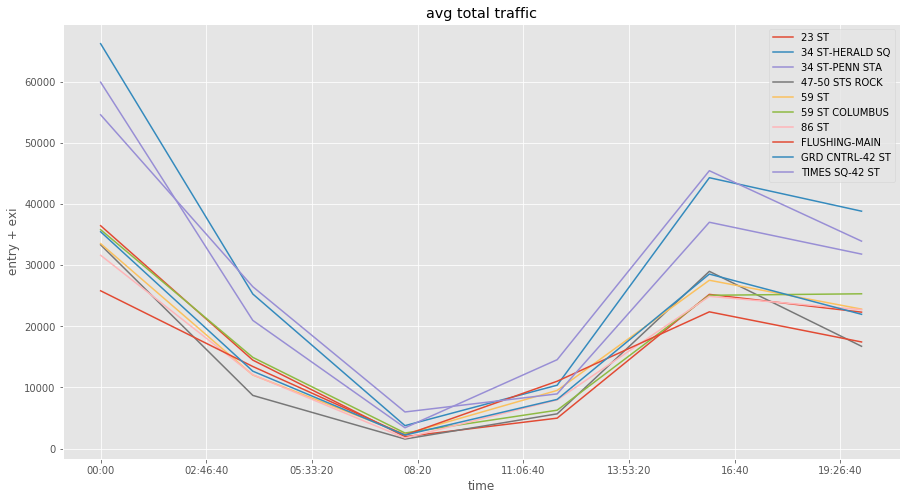

In [50]:
plot_series_trafic_stations(df_2017, n_stations = 10)

#### NOTES: 
* The avg total trafic per station within each 4hour period makes sense, being the peakss of usage at the 12:00 - 16:00 and 20:00 and the lows at 00:00 until abut 06:00.


* Also, the main stations behaved on a very similar way. Thefore, it's good news for our model confecction since we wont be able to use stations as features for passengers flow prediction

## 15. Traffic for all stations - Differente periodicts

In [51]:
dt_init = datetime(2017,1,1,4,0,0)
dt_fim = datetime(2017,2,1,4,0,0)
dt_fim2 = datetime(2017,3,1,4,0,0)

In [52]:
df_2017 = df_2017.set_index("time")
#train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
#train.index = train.Timestamp

# Hourly time series
hourly = df_2017[["total_traffic"]].resample('H').sum()

# Converting to daily mean
daily = df_2017[["total_traffic"]].resample('D').sum()

# Converting to weekly mean
weekly = df_2017[["total_traffic"]].resample('W').sum()

# Converting to monthly mean
monthly = df_2017[["total_traffic"]].resample('M').sum()

df_2017 = df_2017.reset_index()

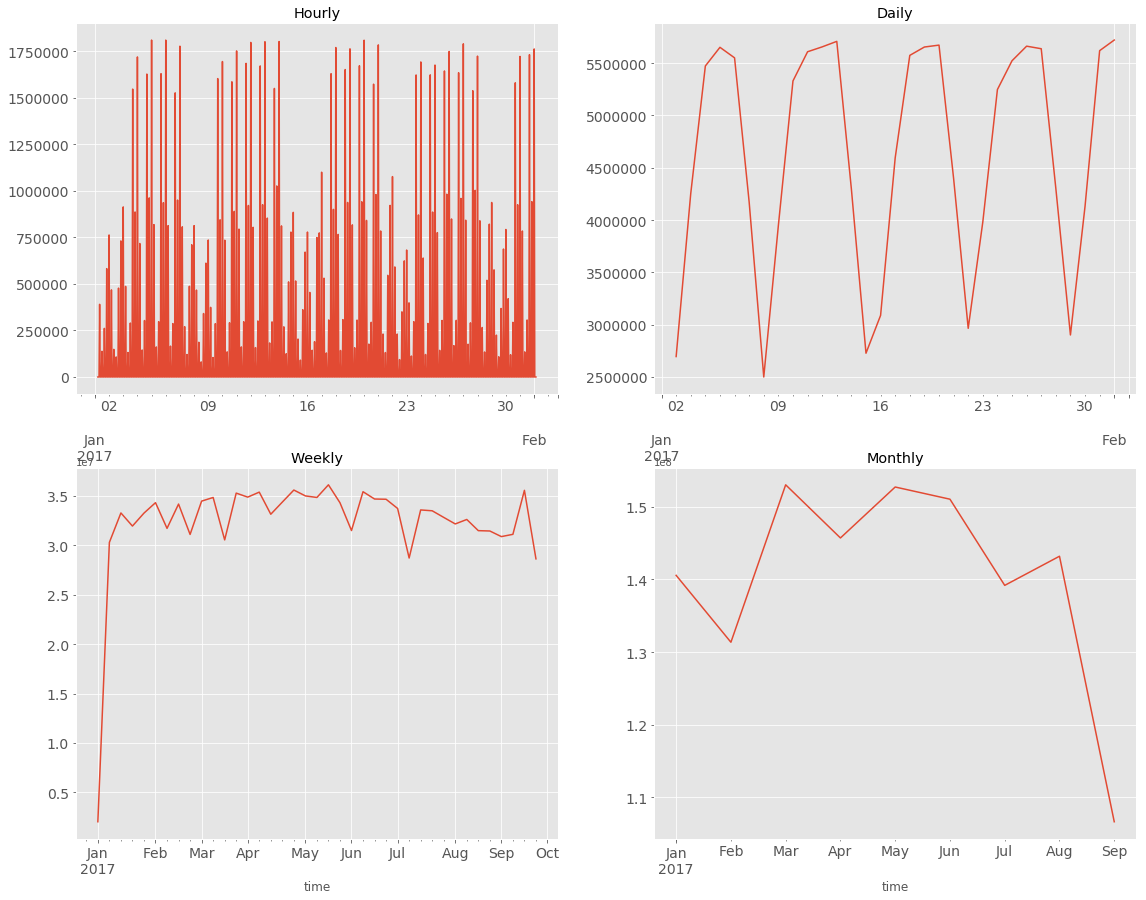

In [53]:
fig, axs = plt.subplots(2, 2)

hourly[(hourly.index > dt_init)&(hourly.index < dt_fim)].total_traffic.plot(figsize=(19,15), title= 'Hourly', fontsize=14, ax=axs[0, 0])
daily[(daily.index > dt_init)&(daily.index < dt_fim)].total_traffic.plot(figsize=(19,15), title= 'Daily', fontsize=14, ax=axs[0, 1])
#daily.total_traffic.plot(figsize=(19,15), title= 'Daily', fontsize=14, ax=axs[0, 1])
weekly.total_traffic.plot(figsize=(19,15), title= 'Weekly', fontsize=14, ax=axs[1, 0])
monthly.total_traffic.plot(figsize=(19,15), title= 'Monthly', fontsize=14, ax=axs[1, 1])

plt.show()

# 16. ACF plotting
 * ACF plot can helps to visualize stationary and non-stationry time-series

In [54]:
import statsmodels.api as sm

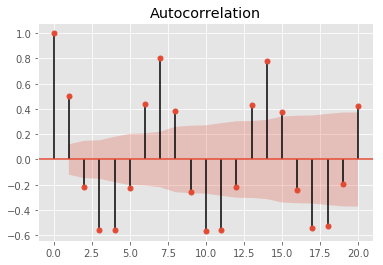

In [55]:
sm.graphics.tsa.plot_acf(daily.values.squeeze(), lags=20)
plt.show()

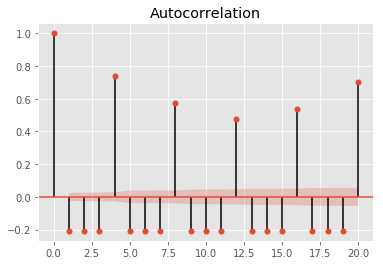

In [56]:
sm.graphics.tsa.plot_acf(hourly.values.squeeze(), lags=20)
plt.show()

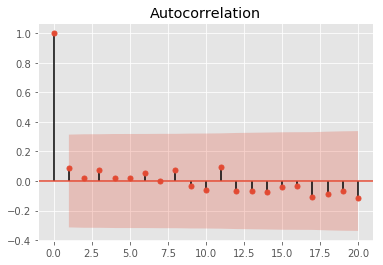

In [57]:
sm.graphics.tsa.plot_acf(weekly.values.squeeze(), lags=20)
plt.show()

## ACF plot:
    * indicates the autocorralation function across of the time lags. In general,for time series ,the first lag points out a great correlation with the current value, as we can see on tehe ACF plotted
    
    * Also, as the lags inscerass, the correlation descreases once the time-dependence starts to fade away.
    
    
    * The ACF for a non-stationary TS decreases slowly. Also, for non-stationary data, the value of r1 is often large and positive.

## Saving table

In [ ]:
df_2017.to_csv("df_2017_2.csv")